In [3]:
from qiskit import *
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit.quantum_info import Statevector, Operator
from qiskit.tools.visualization import plot_error_map, plot_gate_map

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-education')

ibmqfactory.load_account:WARNING:2021-07-27 12:45:35,414: Credentials are already in use. The existing account in the session will be replaced.


### The execute function
- Executes a **list** of QuantumCircuits or Schedule on the specified backend.
- execution is **asynchronous**, and a handle to a **job** instance is returned.


In [5]:
??execute

## Main parameters
- **experiments** - the list of experiments we want to run 
- **backend** - the backend on which we want to run them
- **shots** - the number of shots for which our circuit is executed in the backend
- **initial_layout** - which particular qubit is mapped to which qubit of the actual device
    - can be virtual to physical : [0,3,5] means the first qubit in the circuit would be mapped to the 0th qubit of the device, the second qubit of the circuit would be mapped to the 3rd qubit in the device and the third qubit is mapped to the 5th qubit in the device.
- **optimization_level** - the level upto which we want to optimize our circuit ( 3 is the highest, default is 1 )
- **seed_transpiler/simulator** - the random seed we would need to provide for the transpiler and the simulator to run 
- **coupling_map** - 

    - CouplingMap instance
    - list Must be given as an adjacency matrix, where each entry specifies all two-qubit interactions supported by backend e.g: [[0, 1], [0, 3], [1, 2], [1, 5], [2, 5], [4, 1], [5, 3]]

#### Threee formats to access
 -Note : there is something called the **Aer simulators**
 - They can be called by saying Aer.get_backend('aer_simulator_statevector/unitary/etc.)
 - They are a bit different in the sense that they are part of Aer simulators

In [6]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [7]:
# access the simulators
sv_sim = Aer.get_backend('aer_simulator_statevector')
sv_sim = Aer.get_backend('statevector_simulator')
sv_sim = StatevectorSimulator()
sv_sim = BasicAer.get_backend('statevector_simulator')
# unitary
u_sim = Aer.get_backend('aer_simulator_unitary')
u_sim = Aer.get_backend('unitary_simulator')
u_sim = UnitarySimulator()
u_sim = BasicAer.get_backend('unitary_simulator')
# qasm
q_sim = Aer.get_backend('aer_simulator')
q_sim = Aer.get_backend('qasm_simulator')
q_sim = QasmSimulator()
q_sim = BasicAer.get_backend('qasm_simulator')

- Backends also have a **run_experiment** parameter which runs a single experiment
- There are also parameters like **status** which tells us whether the backend is <font color = 'orange'>operational</font> or not and **provider** which tells us the <font color = 'orange'>provider for this backend</font>

- **properties or options** : the dynamic parameters of a backend which may change : *errors in qubits, gate errors, gate times, faulty qubits and gates, etc.*
- **configuration** : the static parameters of a backend which stay constant : *num qubits, drive frequency, max_shots, open_pulse support, memory, max_experiments, processor type, name, etc.*

- The parameter to the **run()** method is a **Qobj** instance

In [8]:
casb = provider.get_backend('ibmq_casablanca')
belem = provider.get_backend('ibmq_belem')
lagos = provider.get_backend('ibm_lagos')

In [9]:
lagos.configuration().num_qubits

7

## Executing a simple phase estimation circuit

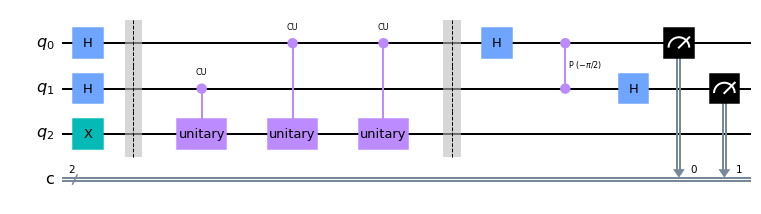

In [10]:
q = QuantumCircuit(3, 2)
q.x(2)
q.h([0, 1])
q.barrier()
u = UnitaryGate(data=np.array([[1, 0],
                               [0, np.exp(2*np.pi*1j*(1/2))]]))
c_gate = u.control(label='CU', num_ctrl_qubits=1, ctrl_state='1')
q.append(c_gate, qargs=[1, 2])
q.append(c_gate, qargs=[0, 2])
q.append(c_gate, qargs=[0, 2])
q.barrier([0, 1, 2])
q.h(0)
q.cp(-np.pi/2, 0, 1)
q.h(1)
# q.barrier()
q.measure([0, 1], [0, 1])
q.draw('mpl')

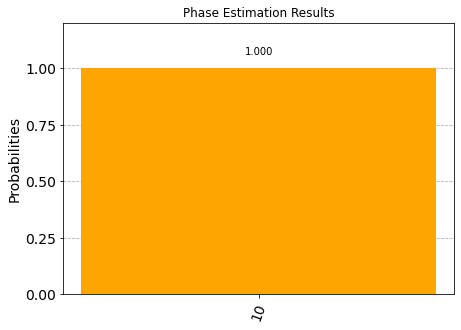

In [11]:
# we should get the state vector 10
res = execute(q, backend=q_sim, shots=1024).result()
counts = res.get_counts()
plot_histogram(counts, color='orange', title='Phase Estimation Results')

### Parameters for the plot_gate_map
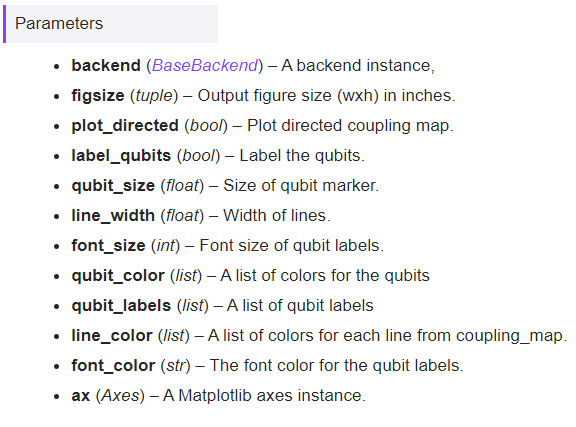

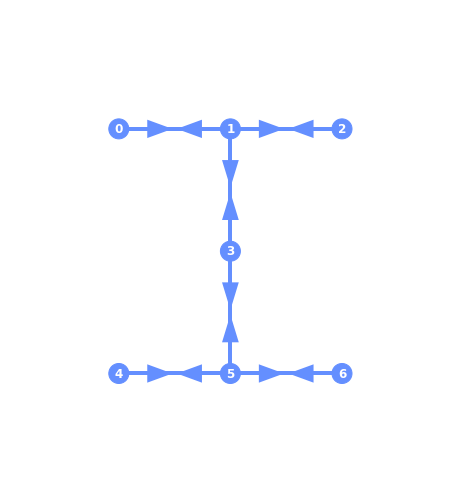

In [12]:
plot_gate_map(lagos, figsize=(8, 9), qubit_size=20, plot_directed=True)  # nice

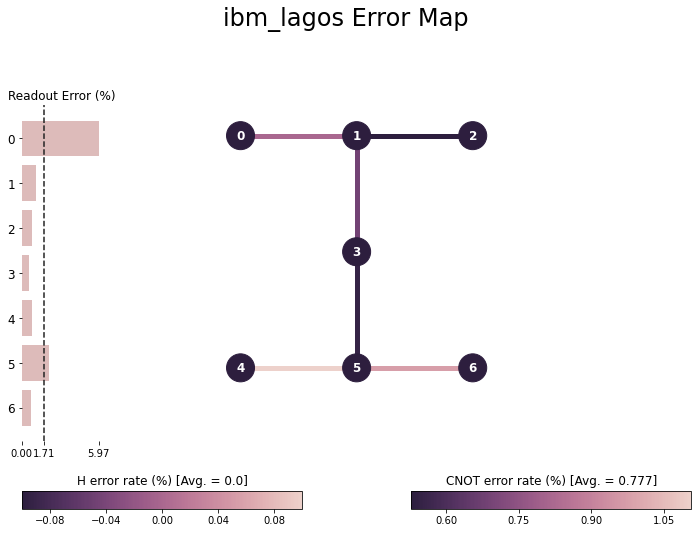

In [13]:
plot_error_map(lagos)

- **jobs** have **status, job_id**
- They can be also cancelled while on the backend 
- Has states like **done**, **cancelled**, **running**, **in_queue**

### Plotting the circuit layout 
- We can also plot how our circuit has been transpiled on a given backend 
- This is actually pretty cool

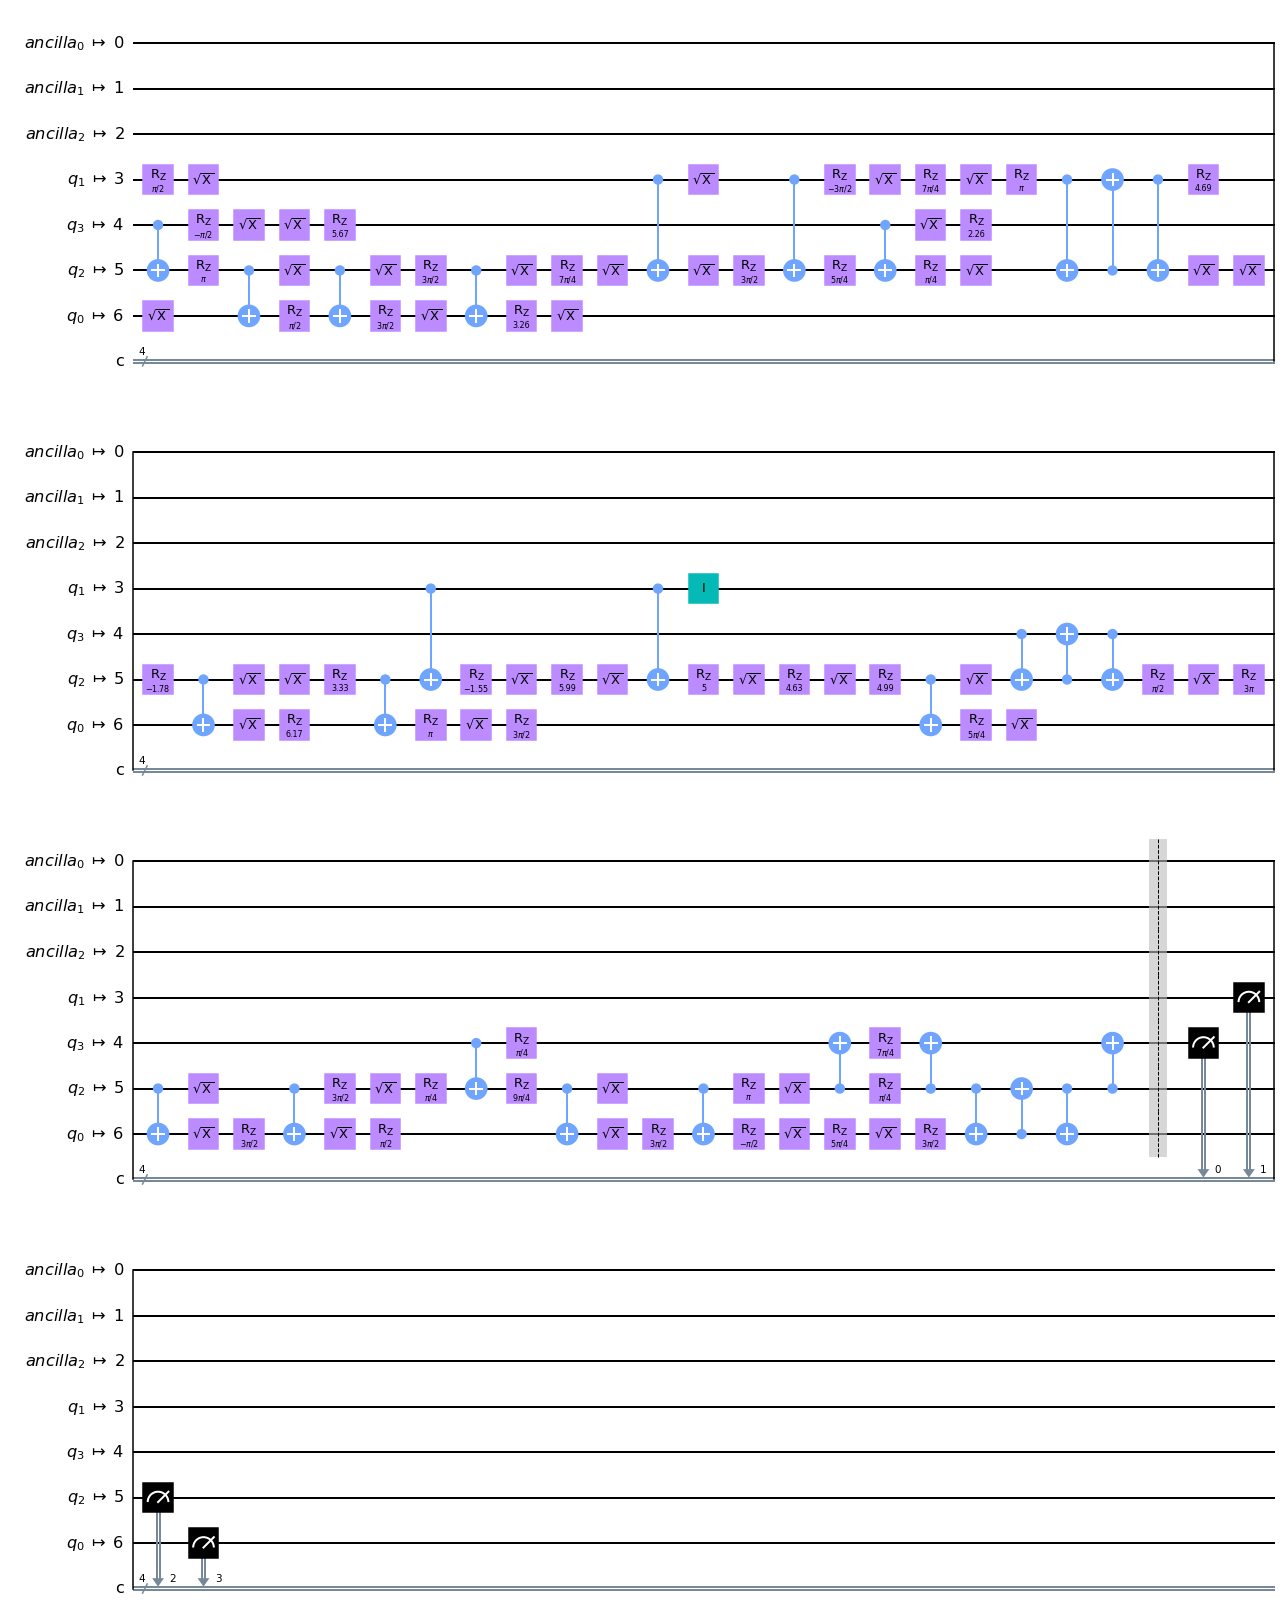

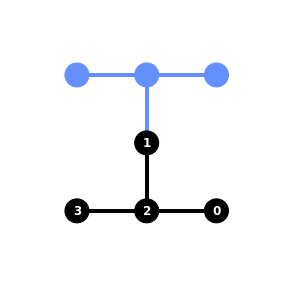

In [14]:
from qiskit.circuit.random import random_circuit
from qiskit.tools.visualization import plot_circuit_layout
cr = random_circuit(num_qubits=4, depth=4, measure=True)
transpiled = transpile(cr, lagos, optimization_level=3)
display(transpiled.draw('mpl'))
plot_circuit_layout(transpiled, lagos)

In [ ]:
job = execute(q, backend=lagos, qobj_id='my_job_1', initial_layout=[1, 3, 5],
              shots=2**12, optimization_level=3)
print(job.result())

In [17]:
print(job.job_id())

60ffb2cd8075100ed2759168


In [18]:
job = lagos.retrieve_job(job.job_id())

In [20]:
job.result()

Result(backend_name='ibm_lagos', backend_version='1.0.1', qobj_id='e96ea343-056a-417b-a864-eed747663b9f', job_id='60ffb2cd8075100ed2759168', success=True, results=[ExperimentResult(shots=4096, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 173, '0x1': 141, '0x2': 3664, '0x3': 118}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1]], creg_sizes=[['c', 2]], global_phase=-3.141592653589793, memory_slots=2, metadata={}, n_qubits=7, name='circuit-5', qreg_sizes=[['q', 7]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]]), memory=False)], date=2021-07-27 12:55:08+05:30, status=Successful completion, status=QobjHeader(backend_name='ibm_lagos', backend_version='1.0.1'), time_taken=6.166232585906982, execution_id='c1b2f626-eeab-11eb-bf4b-bc97e15b19e6', client_version={'qiskit': '0.26.0'})

- Can also retrieve job using **backend.retrieve_job(job_id)** 

In [ ]:
from qiskit.tools.jupyter import * 
%qiskit_job_watcher 

In [ ]:
res_lag = job.result()
res_sim = execute(q, backend=q_sim, shots=2**12, optimization_level=3)

In [ ]:
lag_counts = res_lag.get_counts()
sim_counts = res_sim.result().get_counts()

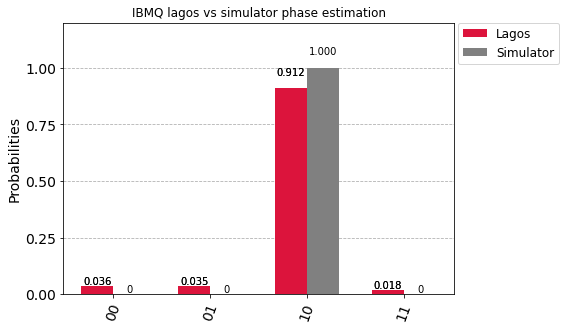

In [27]:
plot_histogram([lag_counts, sim_counts], color=['crimson', 'grey'], title='IBMQ lagos vs simulator phase estimation',
               legend=['Lagos', 'Simulator'])

### Simulating some statevectors on the statevector and the unitary simulators

In [6]:
qr = QuantumRegister(size=2, name='qr')
cr = ClassicalRegister(size=2, name='cr')
qc = QuantumCircuit(qr, cr)

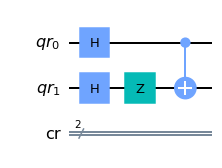

In [7]:
qc.h(qr)
qc.z(qr[1])
qc.cx(qr[0], qr[1])
qc.draw('mpl')

### Getting the statevector

In [8]:
# two ways
# 1. SV sim
res = execute(qc, backend=sv_sim, shots=1024).result()
sv1 = res.get_statevector(decimals=4)
# sv1 = np.around(sv1,4)
print("Statevector :", sv1)

# 2. Statevector evolve
sv2 = Statevector.from_label('00')
sv2 = Statevector.from_int(0, dims=4)
sv2 = sv2.evolve(qc)
sv2 = np.around(sv2, 4)
print("Statevector :", np.around(sv2, 4))

sv1 == sv2

Statevector : [ 0.5-0.j -0.5+0.j -0.5+0.j  0.5-0.j]
Statevector : [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]


array([ True,  True,  True,  True])

### Getting the unitary matrix

In [9]:
# 1. using the unitary simulator
res = execute(qc, backend=u_sim, shots=1024, optimization_level=3).result()
u1 = res.get_unitary(decimals=4)
u1 = np.around(u1, 4)
print(u1)

# 2. Using the Operator.data method
u2 = Operator(data=qc)
u2 = u2.data
u2 = np.around(u2, 4)
print(u2)

u1 == u2

[[ 0.5-0.j  0.5-0.j  0.5+0.j  0.5-0.j]
 [-0.5+0.j  0.5-0.j  0.5-0.j -0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5-0.j  0.5-0.j]
 [ 0.5-0.j -0.5+0.j  0.5+0.j -0.5+0.j]]
[[ 0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]]


array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

### Making Gates and Instructions
- Gates : can have only Unitary operations
- Instructions : can have unitary as well as non-unitary operations

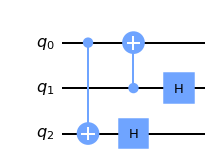

In [119]:
qc = QuantumCircuit(3)
# [c0,c1,c2...], [t0,t1,t2,...]
qc.cx([0, 1], [2, 0])  # nice...
qc.h([1, 2])
qc.draw('mpl')

In [120]:
gate = qc.to_gate()
inst = qc.to_instruction()

In [127]:
gate.label = 'My-gate-cx'
gate

In [130]:
inst.name = 'My-inst'
inst

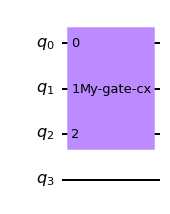

In [131]:
qc = QuantumCircuit(4)
qc = qc.compose(gate, qubits=[0, 1, 2])
qc.draw('mpl')

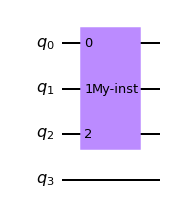

In [132]:
qc = QuantumCircuit(4)
qc = qc.compose(inst, qubits=[0, 1, 2])
(qc.draw('mpl'))

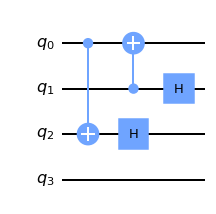

In [133]:
(qc.decompose().draw('mpl'))

### Note : you can't make a Gate out of non-unitary operations

In [ ]:
from qiskit.circuit.random import random_circuit
qc = random_circuit(num_qubits=4, depth=4, measure=True)
qc.draw('mpl')

In [ ]:
# breaks down!
gate2 = qc.to_gate()

In [ ]:
# this works perfect !
inst2 = qc.to_instruction()

In [ ]:
inst2.draw('mpl')